# Spatial evaluation of the SCF param with HMASR 100 km
## fig06

Full analyses: https://github.com/mickaellalande/PhD/blob/master/SCF_parameterizations/2_calibration/HMASR_100km_calibration.ipynb  
Original notebook: https://github.com/mickaellalande/PhD/blob/master/SCF_parameterizations/2_calibration/fig_HMASR_100km_spatial_params.ipynb

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
# phd_v3 env
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
plot.rc['abc.style'] = '(a)' # for EGU journals (only abc in new proplot versions)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Load data

In [2]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'

# Snow depth
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SD_POST.nc')
sd = ds.SD_Post.load()

# SCF
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SWE_SCA_POST.nc')
swe = ds.SWE_Post.load()
scf= ds.SCA_Post.load()

# Mask
mask = xr.open_dataarray('Non_seasonal_snow_mask_100km.nc').load()

# Topo
latlim = slice(mask.lat.min().values.item(0)-0.5, mask.lat.max().values.item(0)+0.5)
lonlim = slice(mask.lon.min().values.item(0)-0.5, mask.lon.max().values.item(0)+0.5)

ds = xr.open_dataset('../data/HMASR_DEM_100km.nc')
topo = ds.elevation_seassnow.load()
topo_std = ds.std_seassnow.load()

train_period = slice('1999-10-01', '2013-09-30') # ~80%
val_period = slice('2013-10-01', '2017-09-30') # ~20%

## Plot

In [3]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

mask_lats = []
mask_lons = []

threshold = 30

for lat in mask.lat.values:
    for lon in mask.lon.values:
        temp = mask.where(mask>threshold)*0+1
        if temp.sel(lat=lat, lon=lon) == 1:
            mask_lats.append(lat)
            mask_lons.append(lon)
            
def plot_hatches_mask(ax):
    for i in range(len(mask_lats)):
        ax.add_patch(
                mpatches.Rectangle(
                    xy=[mask_lons[i]-0.5, mask_lats[i]-0.5], width=1, height=1, transform=ccrs.PlateCarree(),
                    fill=False, zorder=10, color='black', linewidth=0, hatch='//////',
                )
            )

In [4]:
lat_weights = np.cos(np.deg2rad(scf.lat))
frac_seasonal_snow = (1-mask/100).where(scf[0]*0+1 == 1)
temp = (frac_seasonal_snow*lat_weights).where(mask<30)
weights = (temp / temp.sum()).fillna(0)
np.testing.assert_equal(weights.sum().values.item(0), 1)

### Check zones

In [5]:
# Get zone limits for annual cycle
lonlim_TS, latlim_TS, lonlim_HK, latlim_HK, lonlim_TP, latlim_TP, lonlim_HM, latlim_HM = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'TS', 'HK', 'TP', 'HM']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_TS, latlim_TS], [lonlim_HK, latlim_HK], [lonlim_TP, latlim_TP], [lonlim_HM, latlim_HM]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## SCF params

In [6]:
# R01
def R01(swe, zstd):
    return 0.95 * np.tanh(100*swe) * np.sqrt( 1000*swe / ( 1000*swe + 0.15*zstd + 1e-6) )

scf_R01 = R01(swe, topo_std)


# NY07
def NY07(sd, z0, rho_snow, rho_new, m):
    scf = np.tanh(sd/(2.5*z0*(rho_snow/rho_new)**m))
    return scf.where((sd>1e-7) & (swe>1e-7) & (rho_snow<917), other=0).where( (sd*0+1) == 1).where(mask < 30)

scf_NY07_orig = NY07(sd, 0.01, swe/sd*1000, 100, 1.6)
scf_NY07_orch = NY07(sd, 0.01, swe/sd*1000, 50, 1)


# SL12
def SL12(swe, topo_std):
    
    # Initialize with first SCF
    temp = scf.copy()
    temp[1:] = np.nan 
    
    N_melt = 200 / topo_std.where(topo_std > 10, other=10) # eq. (5) in SL12 (modified)
    swe_max = ( 2. * swe[0] ) / ( 1 + np.cos( np.pi * (1 - temp[0])**(1/N_melt) ) )

    for i_time in range(swe.time.size-1):
#         print(i_time)

        delta_swe = swe[i_time+1]-swe[i_time]
                
        melt = (1 - ( 1 / np.pi * np.arccos( 2 * (swe[i_time+1] / swe_max).where(swe[i_time+1] / swe_max < 1) - 1 ) )**N_melt)

        k = 0.1 # 0.1 in SL12
        accu = (1 - ( 1 - (k*delta_swe*1e3).where(k*delta_swe*1e3 < 1, 1).where(delta_swe*0+1 == 1) ) * ( 1. - temp[i_time] ))
        total = accu.where( (delta_swe > 1e-6), melt)
        temp[i_time+1] = total.where(total > 0, 0).where(scf[0]*0+1 == 1) 
        
        swe_max = ( ( 2. * swe[i_time+1] ) / ( 1 + np.cos( np.pi * (1 - temp[i_time+1])**(1/N_melt) ) ) ).where(delta_swe > 1e-6, swe_max)
    
    return temp

scf_SL12 = SL12(swe, topo_std)


# LA22
def LA22(sd, z0, rho_snow, rho_new, m, zstd, zstd_0, m2):
    scf = np.tanh(sd/(2.5*z0*(rho_snow/rho_new)**m + zstd_0*zstd*(rho_snow/rho_new)**m2 ))
    return scf.where((sd>1e-7) & (swe>1e-7) & (rho_snow<917), other=0).where( (sd*0+1) == 1).where(mask < 30)

scf_LA22 = LA22(sd, 0.01, swe/sd*1000, 50, 1, topo_std, 3e-6, 3)

# DNN
scf_DNN = xr.open_dataarray('results/scf_100km_ML3.nc')


## Spatial bias

In [7]:
import warnings
warnings.filterwarnings("ignore")

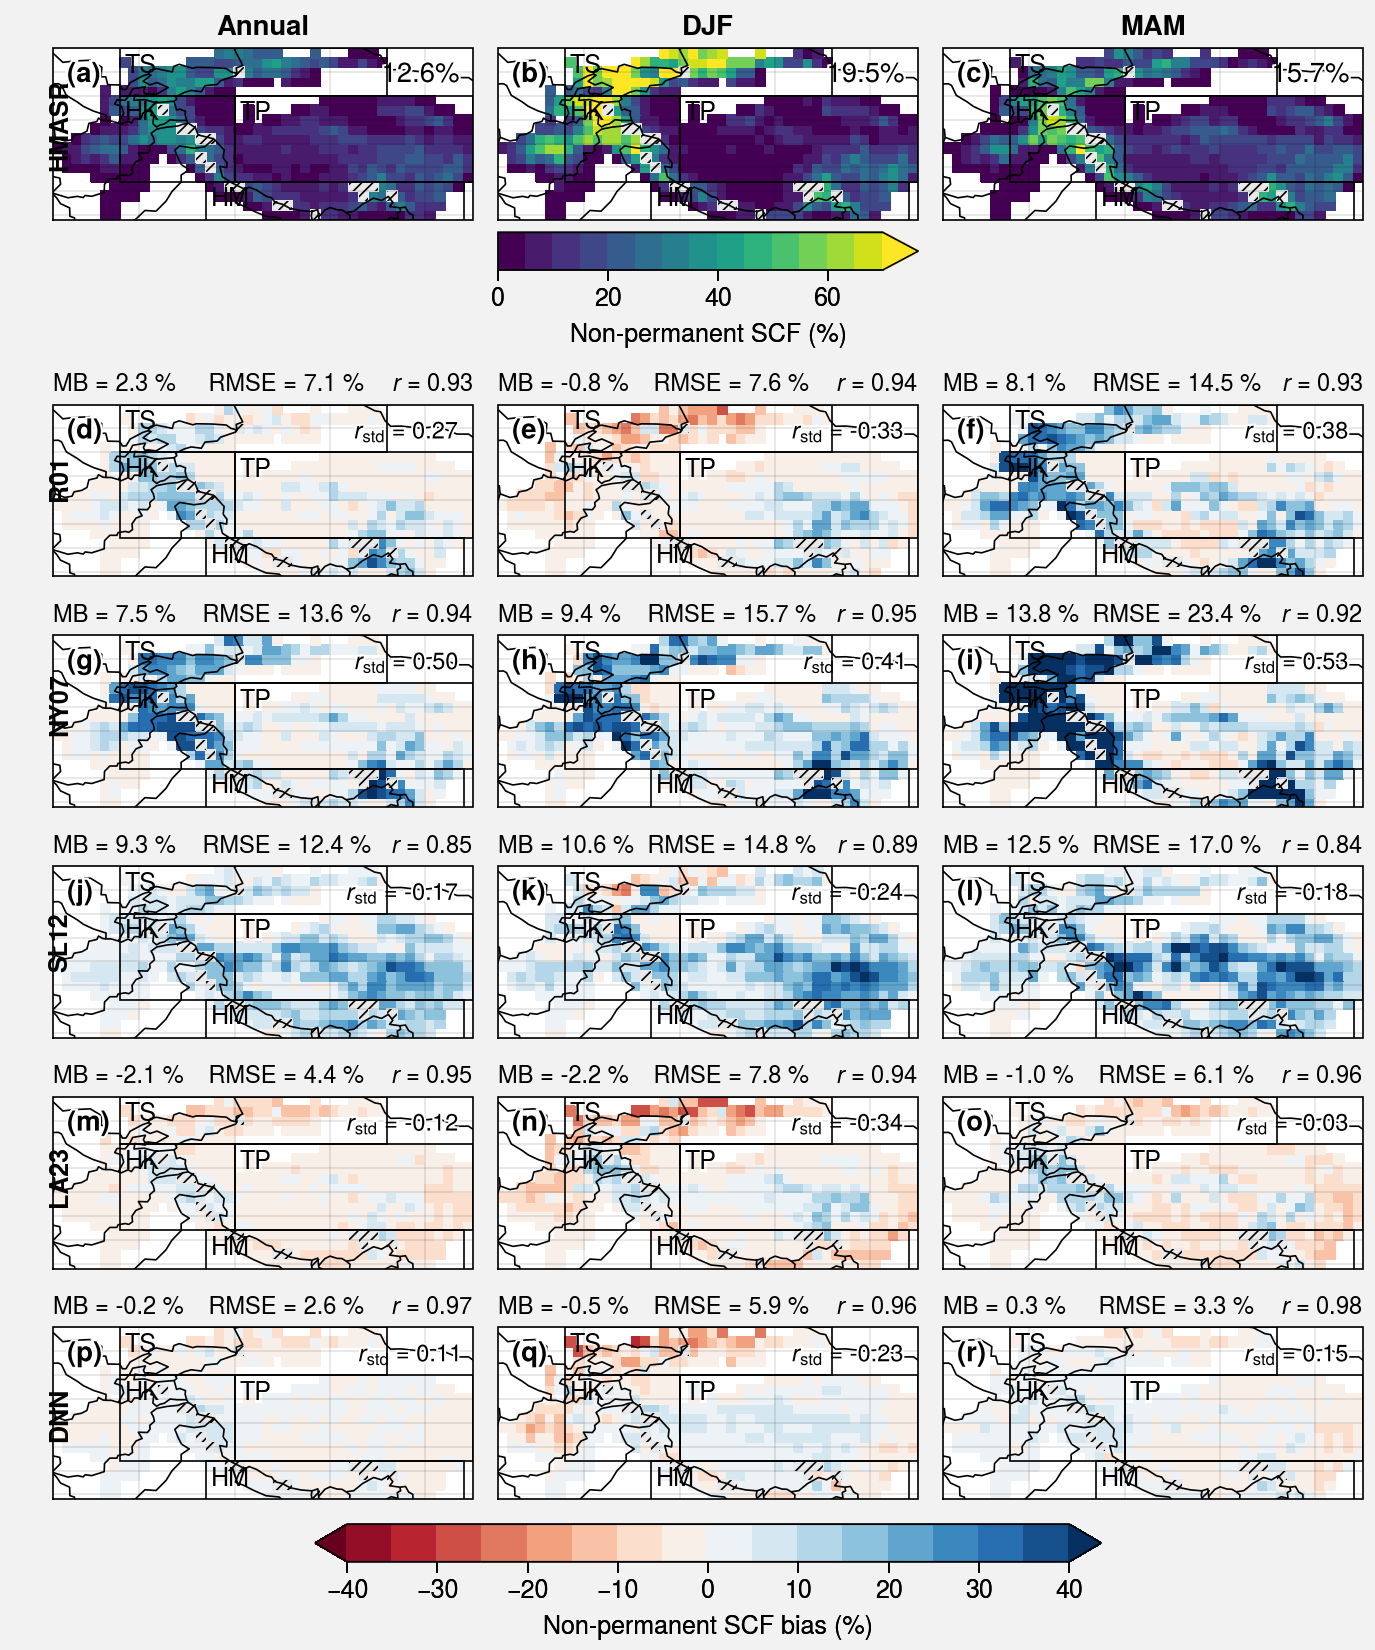

In [14]:
seasons=['Annual', 'DJF', 'MAM']; freq='D'
levels=plot.arange(0, 70, 5); extend='max'; cmap='viridis'
levels_bias=plot.arange(-40, 40, 5); extend_bias='both'; cmap_bias='RdBu'
threshold=30 # percentage of permanent snow in a cell
params = ['R01', 'NY07', 'SL12', 'LA23', 'DNN']
scf_params = [scf_R01, scf_NY07_orch, scf_SL12, scf_LA22, scf_DNN]

fig, axs = plot.subplots(proj='cyl', ncols=len(seasons), nrows=len(params)+1, axwidth=2.1)

# HMASR
scf_ref_seasons = []
for i, season in enumerate(seasons):
    data = u.clim(scf.sel(time=val_period), freq=freq, season=season, skipna=True)*100
    scf_ref_seasons.append(data)
    m = axs[0, i].pcolormesh(data, levels=levels, extend=extend, cmap=cmap)
    axs[0, i].format(urtitle='{:.1f}%'.format(data.weighted(weights).sum().values.item(0)))

# bias
for j, param in enumerate(params):
    for i, season in enumerate(seasons):
        scf_param_clim = u.clim(scf_params[j].sel(time=val_period), freq=freq, season=season, skipna=True)*100
        
        bias = scf_param_clim-scf_ref_seasons[i]
        m_bias = axs[j+1, i].pcolormesh(bias, levels=levels_bias, extend=extend_bias, cmap=cmap_bias, rasterized=True)

        mb = u.weighted_mean(bias, weights).values.item(0)
        rmse = u.weighted_rmse(scf_param_clim, scf_ref_seasons[i], weights).values.item(0)
        r = u.weighted_corr(scf_param_clim, scf_ref_seasons[i], weights).values.item(0)
        r_std = u.weighted_corr(bias, topo_std, weights).values.item(0)
        r_topo = u.weighted_corr(bias, topo, weights).values.item(0)
        axs[j+1, i].format(
            ltitle='MB = {:.1f} %'.format(mb), ctitle='       RMSE = {:.1f} %'.format(rmse), rtitle='$\it{r}$'+' = {:.2}'.format(r),
            urtitle='$\it{r}$'+'$_{std}$'+' = {:.2f}'.format(r_std), titlesize=8.5
        )

# mask
for ax in axs:
    ax.pcolormesh(mask.where(mask>threshold)*0+1, cmap='lightgray', levels=[0, 1, 2, 3])
    plot_hatches_mask(ax)
    u.plot_zones(ax=ax)
#     ax.format(utitle='aze')

# Colorbars
axs[1].colorbar(m, label='Non-permanent SCF (%)', ticks=20, loc='b')
# fig.colorbar(m_bias, label='non-permanent SCF bias [%]', rows=(2, 6), ticks=10, length=0.8)
fig.colorbar(m_bias, label='Non-permanent SCF bias (%)', cols=(1, 3), ticks=10, length=0.6, loc='b')

# for pos, label in zip(np.linspace(0.25, 0.75, 3), ['All points', 'STD < '+str(threshold)+' m', 'STD > '+str(threshold)+' m'][::-1]):
for pos, label in zip(np.append(np.linspace(0.13, 0.70, 5), 0.90), params[::-1] + ['HMASR']):
    fig.text(0.035, pos, label, fontweight='bold', rotation='vertical')

# Format
axs.format(
    borders=True, labels=False, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
#     suptitle=param+' daily non-permanent SCF at 1°x1° predicted from HMASR inputs\n(1999-10-01 to 2017-09-30; grid cells with >30% permanent snow are excluded)',
    abc=True, abcloc='ul',
    collabels=seasons,
#     rowlabels=['HMASR'] + params
)

#  Décalage des collabels entre pdf pour je ne sais quelle raison
fig.save('img/fig06.jpg')

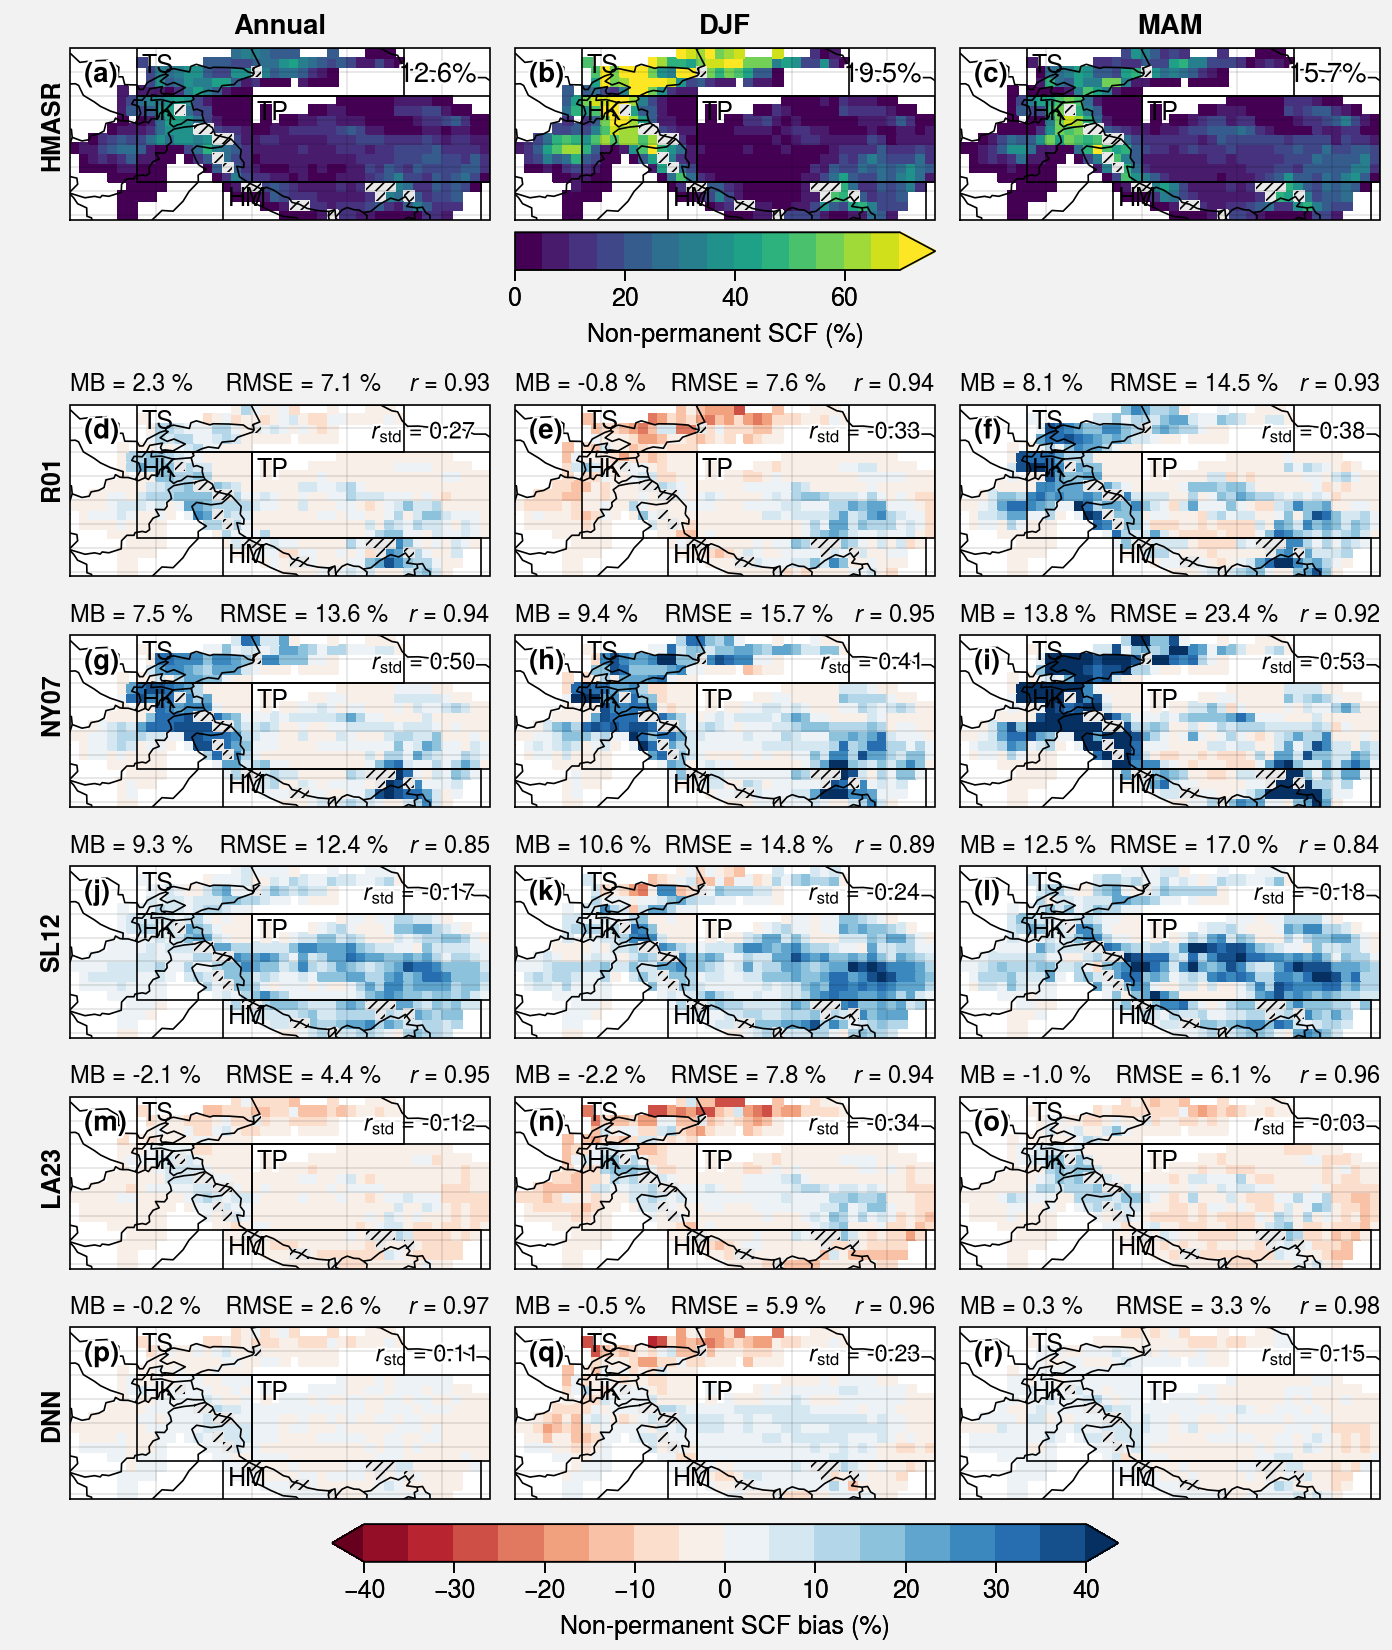

In [15]:
seasons=['Annual', 'DJF', 'MAM']; freq='D'
levels=plot.arange(0, 70, 5); extend='max'; cmap='viridis'
levels_bias=plot.arange(-40, 40, 5); extend_bias='both'; cmap_bias='RdBu'
threshold=30 # percentage of permanent snow in a cell
params = ['R01', 'NY07', 'SL12', 'LA23', 'DNN']
scf_params = [scf_R01, scf_NY07_orch, scf_SL12, scf_LA22, scf_DNN]

fig, axs = plot.subplots(proj='cyl', ncols=len(seasons), nrows=len(params)+1, axwidth=2.1)

# HMASR
scf_ref_seasons = []
for i, season in enumerate(seasons):
    data = u.clim(scf.sel(time=val_period), freq=freq, season=season, skipna=True)*100
    scf_ref_seasons.append(data)
    m = axs[0, i].pcolormesh(data, levels=levels, extend=extend, cmap=cmap)
    axs[0, i].format(urtitle='{:.1f}%'.format(data.weighted(weights).sum().values.item(0)))

# bias
for j, param in enumerate(params):
    for i, season in enumerate(seasons):
        scf_param_clim = u.clim(scf_params[j].sel(time=val_period), freq=freq, season=season, skipna=True)*100
        
        bias = scf_param_clim-scf_ref_seasons[i]
        m_bias = axs[j+1, i].pcolormesh(bias, levels=levels_bias, extend=extend_bias, cmap=cmap_bias, rasterized=True)

        mb = u.weighted_mean(bias, weights).values.item(0)
        rmse = u.weighted_rmse(scf_param_clim, scf_ref_seasons[i], weights).values.item(0)
        r = u.weighted_corr(scf_param_clim, scf_ref_seasons[i], weights).values.item(0)
        r_std = u.weighted_corr(bias, topo_std, weights).values.item(0)
        r_topo = u.weighted_corr(bias, topo, weights).values.item(0)
        axs[j+1, i].format(
            ltitle='MB = {:.1f} %'.format(mb), ctitle='       RMSE = {:.1f} %'.format(rmse), rtitle='$\it{r}$'+' = {:.2}'.format(r),
            urtitle='$\it{r}$'+'$_{std}$'+' = {:.2f}'.format(r_std), titlesize=8.5
        )

# mask
for ax in axs:
    ax.pcolormesh(mask.where(mask>threshold)*0+1, cmap='lightgray', levels=[0, 1, 2, 3])
    plot_hatches_mask(ax)
    u.plot_zones(ax=ax)
#     ax.format(utitle='aze')

# Colorbars
axs[1].colorbar(m, label='Non-permanent SCF (%)', ticks=20, loc='b')
# fig.colorbar(m_bias, label='non-permanent SCF bias [%]', rows=(2, 6), ticks=10, length=0.8)
fig.colorbar(m_bias, label='Non-permanent SCF bias (%)', cols=(1, 3), ticks=10, length=0.6, loc='b')

# for pos, label in zip(np.linspace(0.25, 0.75, 3), ['All points', 'STD < '+str(threshold)+' m', 'STD > '+str(threshold)+' m'][::-1]):
for pos, label in zip(np.append(np.linspace(0.13, 0.70, 5), 0.90), params[::-1] + ['HMASR']):
    fig.text(0.029, pos, label, fontweight='bold', rotation='vertical')

# Format
axs.format(
    borders=True, labels=False, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
#     suptitle=param+' daily non-permanent SCF at 1°x1° predicted from HMASR inputs\n(1999-10-01 to 2017-09-30; grid cells with >30% permanent snow are excluded)',
    abc=True, abcloc='ul',
    collabels=seasons,
#     rowlabels=['HMASR'] + params
)

#  Décalage des collabels entre pdf pour je ne sais quelle raison
fig.save('img/fig06.pdf')